In [ ]:
import os
print("Current directory:", os.getcwd())
print("Files in current directory:")
for item in os.listdir('.'):
    if os.path.isfile(item):
        print(f"  {item}")

Already up to date.
Content of dir:
total 244
drwxr-xr-x 2 root root 135168 Nov 25 10:28 dataset
-rw-r--r-- 1 root root 110184 Nov 25 10:28 dataset.csv
drwxr-xr-x 4 root root   4096 Nov 25 10:58 ML_Project_first_term


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

data = pd.read_csv('dataset.csv')
data['class_combined'] = data['type'] + '_' + data['state']

X = data[['name']]
y = data['class_combined']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)


X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176,
    random_state=42,
    stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 2564
Validation size: 548
Test size: 550


In [ ]:
import os
import numpy as np
from PIL import Image
import torchvision.transforms as T
import torch

train_transforms = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor()
])

test_transforms = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

def load_images_as_numpy(df, labels, root_dir, transform, n_aug=1):
    X_list = []
    y_list = []
    for i in range(len(df)):
        img_path = os.path.join(root_dir, df.iloc[i]["name"])
        img = Image.open(img_path).convert("RGB")
        for _ in range(n_aug):
            img_t = transform(img)
            img_np = img_t.numpy().reshape(-1)
            X_list.append(img_np)
            y_list.append(labels.iloc[i])
    X = np.stack(X_list, axis=0)
    y = np.array(y_list)
    return X, y


root_dir = "datasetV1"

X_train_np, y_train_np = load_images_as_numpy(X_train, y_train, root_dir, train_transforms, n_aug=4)
X_val_np, y_val_np     = load_images_as_numpy(X_val,   y_val,   root_dir, test_transforms)
X_test_np, y_test_np   = load_images_as_numpy(X_test,  y_test,  root_dir, test_transforms)

print(X_train_np.shape, y_train_np.shape)
print(X_val_np.shape, y_val_np.shape)
print(X_test_np.shape, y_test_np.shape)

(10256, 49152) (10256,)
(548, 49152) (548,)
(550, 49152) (550,)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_val_scaled   = scaler.transform(X_val_np)
X_test_scaled  = scaler.transform(X_test_np)

max_samples = 2000

if X_train_scaled.shape[0] > max_samples:
    idx = np.random.choice(X_train_scaled.shape[0], max_samples, replace=False)
    X_for_pca = X_train_scaled[idx]
else:
    X_for_pca = X_train_scaled

pca_full = PCA()
pca_full.fit(X_for_pca)

expl_var_ratio = pca_full.explained_variance_ratio_
cum_expl_var = np.cumsum(expl_var_ratio)

variance_levels = [0.80, 0.85, 0.90, 0.95]

n_components_list = []
for level in variance_levels:
    n_components = np.argmax(cum_expl_var >= level) + 1
    n_components_list.append(n_components)
    print(f"Varianza {level*100:.0f}% -> {n_components} componenti")

print("Lista componenti:", n_components_list)





Varianza 80% -> 45 componenti
Varianza 85% -> 81 componenti
Varianza 90% -> 162 componenti
Varianza 95% -> 373 componenti
Lista componenti: [np.int64(45), np.int64(81), np.int64(162), np.int64(373)]


In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

knn_accuracies = []
neighbors_list = [1, 3, 5, 7, 9]

for n_components in n_components_list:
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)

    for n_neighbors in neighbors_list:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train_pca, y_train_np)
        y_val_pred = knn.predict(X_val_pca)
        acc = accuracy_score(y_val_np, y_val_pred)
        knn_accuracies.append(acc)


print("Accuracy kNN per ciascun livello di varianza:")
acc_idx = 0
for level, n_comp in zip(variance_levels, n_components_list):
    print(f"Varianza {level*100:.0f}% (componenti = {n_comp}):")
    for n_neighbors in neighbors_list:
        acc = knn_accuracies[acc_idx]
        print(f"  k = {n_neighbors}: {acc*100:.2f}%")
        acc_idx += 1

Accuracy kNN per ciascun livello di varianza:
Varianza 80% (componenti = 45):
  k = 1: 37.96%
  k = 3: 37.04%
  k = 5: 39.60%
  k = 7: 38.14%
  k = 9: 38.69%
Varianza 85% (componenti = 81):
  k = 1: 37.77%
  k = 3: 36.13%
  k = 5: 37.23%
  k = 7: 38.50%
  k = 9: 38.50%
Varianza 90% (componenti = 162):
  k = 1: 38.32%
  k = 3: 36.68%
  k = 5: 38.69%
  k = 7: 38.87%
  k = 9: 37.77%
Varianza 95% (componenti = 373):
  k = 1: 37.96%
  k = 3: 36.13%
  k = 5: 36.31%
  k = 7: 37.04%
  k = 9: 37.04%


In [ ]:
from sklearn.decomposition import PCA

n_components = n_components_list[1]

pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)


(10256, 91) (548, 91) (550, 91)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

C_values = [10, 20, 50] #smaller values are worse, best
#no gamma cause scale is better than auto
best_svm_acc = 0.0
best_svm_params = None

for C in C_values:
  svm = SVC(kernel="rbf", C=C)
  svm.fit(X_train_pca, y_train_np)
  y_val_pred = svm.predict(X_val_pca)
  acc = accuracy_score(y_val_np, y_val_pred)
  print(f"SVM RBF, C={C} -> val acc = {acc*100:.2f}%")
  if acc > best_svm_acc:
      best_svm_acc = acc
      best_svm_params = C

print("Miglior SVM su validation:")
print("  C =", best_svm_params)
print("  accuracy =", best_svm_acc*100, "%")


SVM RBF, C=10 -> val acc = 48.36%
SVM RBF, C=20 -> val acc = 48.91%
SVM RBF, C=50 -> val acc = 48.54%
Miglior SVM su validation:
  C = 20
  accuracy = 48.9051094890511 %


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

n_estimators_list = [400]
max_depth_list = [30, 35, 40, 45]
max_features_list = ["sqrt"]

best_rf_acc = 0.0
best_rf_params = None

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for max_features in max_features_list:
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                max_features=max_features,
                random_state=42,
                n_jobs=-1
            )
            rf.fit(X_train_pca, y_train_np)
            y_val_pred = rf.predict(X_val_pca)
            acc = accuracy_score(y_val_np, y_val_pred)
            print(f"RF, n_estimators={n_estimators}, max_depth={max_depth}, "
                  f"max_features={max_features} -> val acc = {acc*100:.2f}%")
            if acc > best_rf_acc:
                best_rf_acc = acc
                best_rf_params = (n_estimators, max_depth, max_features)

print("Miglior RF su validation:")
print("  n_estimators =", best_rf_params[0])
print("  max_depth    =", best_rf_params[1])
print("  max_features =", best_rf_params[2])
print("  accuracy     =", best_rf_acc*100, "%")


RF, n_estimators=400, max_depth=30, max_features=sqrt -> val acc = 49.27%
RF, n_estimators=400, max_depth=35, max_features=sqrt -> val acc = 49.09%
RF, n_estimators=400, max_depth=40, max_features=sqrt -> val acc = 48.91%
RF, n_estimators=400, max_depth=45, max_features=sqrt -> val acc = 48.91%
Miglior RF su validation:
  n_estimators = 400
  max_depth    = 30
  max_features = sqrt
  accuracy     = 49.27007299270073 %


In [ ]:
from sklearn.decomposition import PCA

n_components_lda = n_components_list[1]

pca_lda = PCA(n_components=n_components_lda, random_state=42)
X_train_pca_lda = pca_lda.fit_transform(X_train_scaled)
X_val_pca_lda = pca_lda.transform(X_val_scaled)
X_test_pca_lda = pca_lda.transform(X_test_scaled)

print(X_train_pca_lda.shape, X_val_pca_lda.shape, X_test_pca_lda.shape)


(10256, 81) (548, 81) (550, 81)


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

n_classes = len(np.unique(y_train_np))
n_lda_components = min(n_classes - 1, X_train_pca_lda.shape[1])

lda = LinearDiscriminantAnalysis(n_components=n_lda_components)
X_train_lda = lda.fit_transform(X_train_pca_lda, y_train_np)
X_val_lda = lda.transform(X_val_pca_lda)
X_test_lda = lda.transform(X_test_pca_lda)

print(X_train_lda.shape, X_val_lda.shape, X_test_lda.shape)


(10256, 17) (548, 17) (550, 17)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm_lda = SVC(kernel="rbf", C=20)
svm_lda.fit(X_train_lda, y_train_np)
y_val_pred_lda = svm_lda.predict(X_val_lda)
acc_lda = accuracy_score(y_val_np, y_val_pred_lda)

print("SVM RBF su PCA(85% variance)+LDA -> val acc = ", acc_lda * 100, "%")


SVM RBF su PCA(85% variance)+LDA -> val acc =  42.700729927007295 %


In [ ]:
from sklearn.decomposition import PCA

pca_cv = PCA(n_components=n_components_list[1], random_state=42)
X_train_pca_cv = pca_cv.fit_transform(X_train_scaled)

print(X_train_pca_cv.shape)


(10256, 81)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_scores = []
rf_scores = []

for train_idx, val_idx in kf.split(X_train_pca_cv, y_train_np):
    X_tr, X_va = X_train_pca_cv[train_idx], X_train_pca_cv[val_idx]
    y_tr, y_va = y_train_np[train_idx], y_train_np[val_idx]

    svm = SVC(kernel="rbf", C=20)
    svm.fit(X_tr, y_tr)
    y_pred_svm = svm.predict(X_va)
    svm_scores.append(accuracy_score(y_va, y_pred_svm))

    rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=30,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_tr, y_tr)
    y_pred_rf = rf.predict(X_va)
    rf_scores.append(accuracy_score(y_va, y_pred_rf))

svm_scores = np.array(svm_scores)
rf_scores = np.array(rf_scores)

print("SVM CV accuracies:", svm_scores * 100)
print("SVM CV mean:", svm_scores.mean() * 100, "std:", svm_scores.std() * 100)

print("RF CV accuracies:", rf_scores * 100)
print("RF CV mean:", rf_scores.mean() * 100, "std:", rf_scores.std() * 100)


SVM CV accuracies: [79.87329435 81.13115553 77.91321307 79.42467089 79.27840078]
SVM CV mean: 79.52414692400322 std: 1.0363180144758
RF CV accuracies: [77.38791423 79.66845441 77.96196977 78.59580692 77.18186251]
RF CV mean: 78.15920156857825 std: 0.9008267942784873


Validation accuracy SVM best: 48.91%


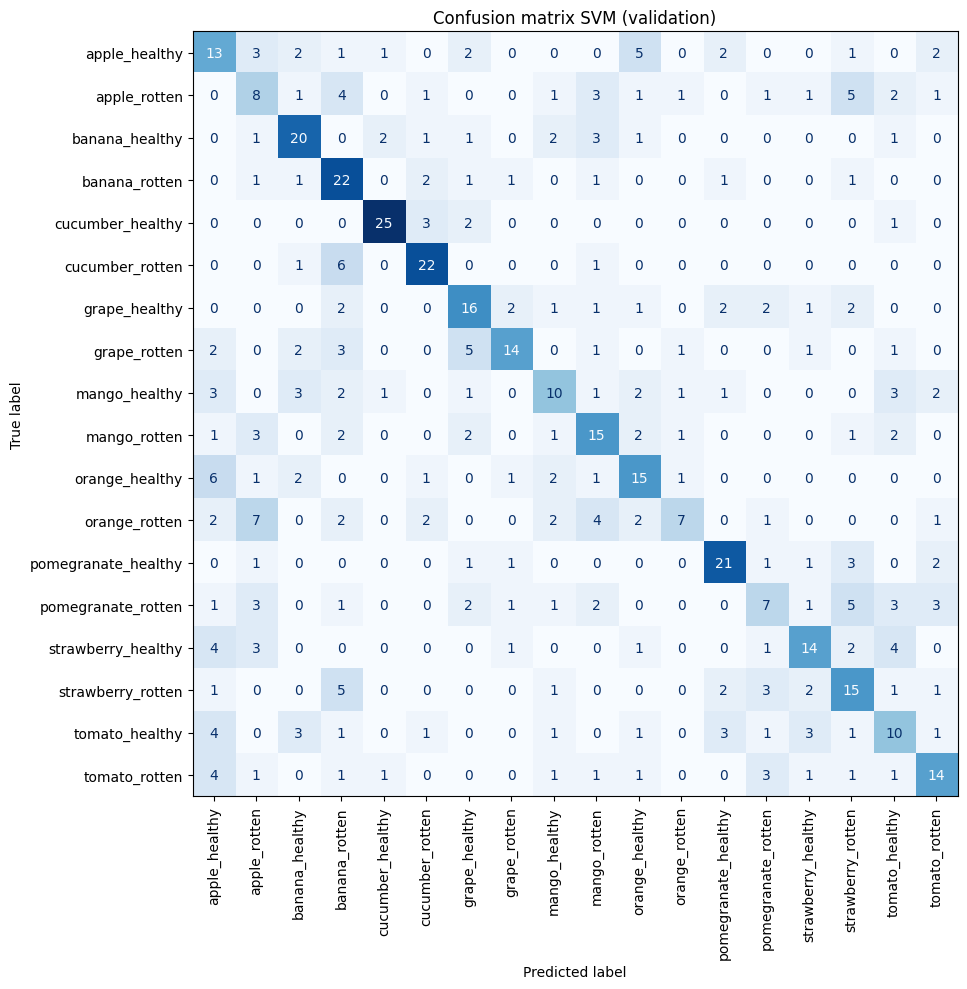

Classification report SVM (validation):
                     precision    recall  f1-score   support

      apple_healthy      0.317     0.406     0.356        32
       apple_rotten      0.250     0.267     0.258        30
     banana_healthy      0.571     0.625     0.597        32
      banana_rotten      0.423     0.710     0.530        31
   cucumber_healthy      0.833     0.806     0.820        31
    cucumber_rotten      0.667     0.733     0.698        30
      grape_healthy      0.485     0.533     0.508        30
       grape_rotten      0.667     0.467     0.549        30
      mango_healthy      0.435     0.333     0.377        30
       mango_rotten      0.441     0.500     0.469        30
     orange_healthy      0.469     0.500     0.484        30
      orange_rotten      0.583     0.233     0.333        30
pomegranate_healthy      0.656     0.677     0.667        31
 pomegranate_rotten      0.350     0.233     0.280        30
 strawberry_healthy      0.560     0.467    

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

svm_best = SVC(kernel="rbf", C=20, gamma="scale")
svm_best.fit(X_train_pca, y_train_np)

y_val_pred_svm = svm_best.predict(X_val_pca)
val_acc_svm = accuracy_score(y_val_np, y_val_pred_svm)
print(f"Validation accuracy SVM best: {val_acc_svm*100:.2f}%")

labels = np.unique(y_train_np)
cm_svm = confusion_matrix(y_val_np, y_val_pred_svm, labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=labels)
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=False)
plt.title("Confusion matrix SVM (validation)")
plt.tight_layout()
plt.show()

print("Classification report SVM (validation):")
print(classification_report(y_val_np, y_val_pred_svm, digits=3))
